The following code studies the output-weighted measure and can be used to replicate **Supplementary Fig. 10**.

Currently showing for "Excessive edge" setting. To consider "Missing edge" and "Reversed edge", change Mis_func accordingly.

In [1]:
from argparse import Namespace
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from data import synthetic_instance, gen_dag
from run import run
from visualize import *

import warnings
warnings.filterwarnings('ignore')

### Generate synthetic instances

In [10]:
seed = 1234
np.random.seed(seed)

# generate problem instantiation
nnodes = 10
sigma_square = np.ones(nnodes)
DAG_type = 'complete'

num_instances = 10
a_size = 5

problems = []
graph = gen_dag(nnodes=nnodes, DAG_type=DAG_type)
for _ in range(num_instances):
	problem = synthetic_instance(
		nnodes=nnodes, 
		DAG_type=DAG_type,
		std=True,
		sigma_square=sigma_square, 
		a_size=a_size,
		a_target_nodes=[i+nnodes//2 for i in range(a_size)], 
		prefix_DAG=graph
		)
	problems.append(problem)

there are no undirected edges
plotting...


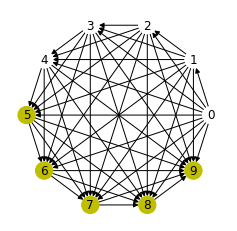

In [11]:
draw(
	problem.DAG, 
	colored_set = set(i for i in range(problem.nnodes) if problem.a_target[i]!=0), 
	affected_set=set().union(*[problem.DAG.descendants_of(i) for i in range(problem.nnodes) if problem.a_target[i]!=0]),
	)

### Mis-specification

In [12]:
def remove_edge(dag):   
    
    if dag.arcs:
        arc = list(dag.arcs)[np.random.choice(len(dag.arcs))]
        dag.remove_arc(*arc)
            
    return


def add_edge(dag):

    if len(dag.arcs) < dag.nnodes * (dag.nnodes-1) /2:
        for i in np.random.permutation(len(dag.nodes)):
            node = list(dag.nodes)[i]
            non_ancestor = dag.nodes - dag.ancestors_of(node)-{node} - dag.children_of(node)

            if non_ancestor:
                point_node = list(non_ancestor)[np.random.choice(len(non_ancestor))]
                dag.add_arc(node,point_node)
                break
                 
    return

def reverse_edge(dag, reversed_list):
    
    for i in np.random.permutation(len(dag.arcs)):
        j, k = list(dag.arcs)[i]
        if dag.children_of(j).intersection(dag.ancestors_of(k)):
            continue
        if (k,j) in reversed_list:
            continue
        dag.remove_arc(j, k)
        dag.add_arc(k, j)
        reversed_list.append((j,k))
        break
    
    return

def Remove_edge(Dag, num_edge=1):
    dag = deepcopy(Dag)
    for _ in range(num_edge):
        remove_edge(dag)
    return dag

def Add_edge(Dag, num_edge=1):
    dag = deepcopy(Dag)
    for _ in range(num_edge):
        add_edge(dag)
    return dag

def Reverse_edge(Dag, num_edge=1):
    dag = deepcopy(Dag)
    reversed_list = []
    for _ in range(num_edge):
        reverse_edge(dag, reversed_list)
    return dag

### Run 5 methods

In [13]:
# options for testing
opts = Namespace(n=1, T=50, W=0, R=10, time=False)

In [14]:
# misspecified setting
num_edge_max = 3
Mis_func = Remove_edge

In [15]:
acqs = ['greedy', 'maxv','cv', 'civ', 'civ', 'grad']
measure = [None, None, None, 'unif', 'ow', None]
known_variance = [False, True, True, True, True, True]
name = ['greedy', 'maxv', 'cv', 'civ', 'civow', 'grad']

Data = []
Mis_DAG = []

for num_edge in range(1,1+num_edge_max,1):
    MSEs = []
    As = []
    Probs = []
    for i in range(num_instances):
        problem = problems[i]

        DAG = deepcopy(problem.DAG)
        mis_DAG = Mis_func(DAG, num_edge)
        Mis_DAG.append(mis_DAG)
        problem.DAG = mis_DAG

        A = {}
        Prob = {}
        Time = {}

        opts.active = False
        A['passive'], Prob['passive'] = run(problem, opts)

        opts.active = True
        for a in range(len(acqs)):
            opts.acq = acqs[a]
            opts.measure = measure[a]
            opts.known_noise = known_variance[a]
            A[name[a]], Prob[name[a]] = run(problem, opts)

        print(f'Graph {i+1}')

        As.append(A)
        Probs.append(Prob)

        problem.DAG = DAG

    mu_MSEs = []
    for i in range(num_instances):
        Prob = Probs[i]
        problem = problems[i]
        mu_mses = {k:[] for k in ['passive', 'greedy', 'maxv', 'cv', 'civ', 'civow', 'grad']}
        for r in range(opts.R):
            for k in ['passive', 'greedy', 'maxv', 'cv', 'civ', 'civow', 'grad']:
                mse = []
                for prob in Prob[k][r]:
                    errs = abs(np.dot(problem.A,np.dot(np.eye(problem.nnodes)-np.array(prob['mean']),problem.mu_target)) - problem.mu_target)
                    mse.append(np.linalg.norm(np.concatenate(errs)) / np.linalg.norm(problem.mu_target))
                mu_mses[k].append(mse)
        mu_MSEs.append(mu_mses)

    data = []
    for k in ['passive', 'greedy', 'maxv', 'cv', 'civ', 'civow', 'grad']:
        data.append([np.array(mu_MSEs[i][k]).mean(axis=0)[-1] for i in range(num_instances)])

    Data += [data]

 20%|██        | 2/10 [00:01<00:04,  1.85it/s]

Optimization fails...
Iteration limit reached
1st initialization (last round) failed...


 70%|███████   | 7/10 [00:03<00:01,  1.79it/s]

Optimization fails...
Iteration limit reached
1st initialization (last round) failed...


 90%|█████████ | 9/10 [00:04<00:00,  1.81it/s]

Optimization fails...
Iteration limit reached
2nd initialization (estimate) failed...


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Graph 1


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Graph 2


  0%|          | 0/10 [00:00<?, ?it/s]

Optimization fails...
Iteration limit reached
2nd initialization (estimate) failed...


 50%|█████     | 5/10 [00:12<00:12,  2.43s/it]

Optimization fails...
Iteration limit reached
2nd initialization (estimate) failed...


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Graph 3


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Graph 4


  0%|          | 0/10 [00:00<?, ?it/s]

Optimization fails...
Iteration limit reached
2nd initialization (estimate) failed...


 70%|███████   | 7/10 [00:16<00:07,  2.46s/it]

Optimization fails...
Iteration limit reached
2nd initialization (estimate) failed...


 40%|████      | 4/10 [00:02<00:03,  1.90it/s]

Optimization fails...
Iteration limit reached
1st initialization (last round) failed...


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Graph 5


 50%|█████     | 5/10 [00:02<00:02,  2.06it/s]

Optimization fails...
Iteration limit reached


 70%|███████   | 7/10 [00:03<00:01,  1.74it/s]

Optimization fails...
Iteration limit reached
2nd initialization (estimate) failed...
Optimization fails...
Iteration limit reached


 80%|████████  | 8/10 [00:04<00:01,  1.86it/s]

Optimization fails...
Iteration limit reached
2nd initialization (estimate) failed...


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Graph 6


 90%|█████████ | 9/10 [00:04<00:00,  1.89it/s]

Optimization fails...
Iteration limit reached
1st initialization (last round) failed...


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Graph 7


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Graph 8


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Graph 9


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Graph 10


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Graph 1


  0%|          | 0/10 [00:00<?, ?it/s]

Optimization fails...
Iteration limit reached
1st initialization (last round) failed...


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Graph 2


 40%|████      | 4/10 [00:07<00:11,  1.91s/it]

Optimization fails...
Iteration limit reached
1st initialization (last round) failed...


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Graph 3


 20%|██        | 2/10 [00:04<00:18,  2.25s/it]

Optimization fails...
Iteration limit reached
2nd initialization (estimate) failed...


 30%|███       | 3/10 [00:06<00:15,  2.28s/it]

Optimization fails...
Iteration limit reached
2nd initialization (estimate) failed...


 40%|████      | 4/10 [00:09<00:13,  2.30s/it]

Optimization fails...
Iteration limit reached


 60%|██████    | 6/10 [00:13<00:09,  2.30s/it]

Optimization fails...
Iteration limit reached
both initializations failed...
Optimization fails...
Iteration limit reached
2nd initialization (estimate) failed...


 80%|████████  | 8/10 [00:18<00:04,  2.27s/it]

Optimization fails...
Iteration limit reached
2nd initialization (estimate) failed...


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Graph 4


 40%|████      | 4/10 [00:02<00:03,  1.95it/s]

Optimization fails...
Iteration limit reached
1st initialization (last round) failed...


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Graph 5


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Graph 6


 20%|██        | 2/10 [00:01<00:04,  1.71it/s]

Optimization fails...
Iteration limit reached
1st initialization (last round) failed...


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Graph 7


 10%|█         | 1/10 [00:00<00:05,  1.70it/s]

Optimization fails...
Inequality constraints incompatible
1st initialization (last round) failed...


 20%|██        | 2/10 [00:01<00:04,  1.77it/s]

Optimization fails...
Iteration limit reached
2nd initialization (estimate) failed...


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Graph 8


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Graph 9


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Graph 10


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Graph 1


 70%|███████   | 7/10 [00:03<00:01,  1.98it/s]

Optimization fails...
Iteration limit reached
1st initialization (last round) failed...


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Graph 2


 80%|████████  | 8/10 [00:03<00:00,  2.23it/s]

Optimization fails...
Iteration limit reached
1st initialization (last round) failed...


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Graph 3


 80%|████████  | 8/10 [00:04<00:01,  1.76it/s]

Optimization fails...
Iteration limit reached
2nd initialization (estimate) failed...


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Graph 4


 20%|██        | 2/10 [00:04<00:18,  2.30s/it]

Optimization fails...
Inequality constraints incompatible
2nd initialization (estimate) failed...


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Graph 5


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Graph 6


  0%|          | 0/10 [00:00<?, ?it/s]

Optimization fails...
Iteration limit reached
2nd initialization (estimate) failed...


 40%|████      | 4/10 [00:09<00:14,  2.46s/it]

Optimization fails...
Iteration limit reached
2nd initialization (estimate) failed...


 70%|███████   | 7/10 [00:03<00:01,  2.28it/s]

Optimization fails...
Iteration limit reached
1st initialization (last round) failed...


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Graph 7


 90%|█████████ | 9/10 [00:20<00:02,  2.40s/it]

Optimization fails...
Iteration limit reached
1st initialization (last round) failed...


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Graph 8


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Graph 9


  0%|          | 0/10 [00:00<?, ?it/s]

Optimization fails...
Iteration limit reached
2nd initialization (estimate) failed...


 20%|██        | 2/10 [00:03<00:14,  1.78s/it]

Optimization fails...
Iteration limit reached
2nd initialization (estimate) failed...


 20%|██        | 2/10 [00:01<00:04,  1.73it/s]

Optimization fails...
Iteration limit reached
2nd initialization (estimate) failed...


 80%|████████  | 8/10 [00:04<00:00,  2.04it/s]

Optimization fails...
Iteration limit reached
1st initialization (last round) failed...


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Graph 10


### Plot results

<Figure size 432x288 with 0 Axes>

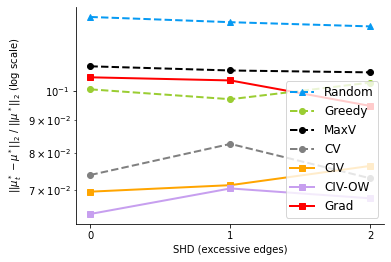

In [8]:
#Adding edge
plt.clf()
fig, ax = plt.subplots(1,1,figsize=(5.6,3.8))
plt.rcParams.update({'font.size': 12})

plt.yscale('log')

labels = ['Random', 'Greedy', 'MaxV', 'CV', 'CIV', 'CIV-OW', 'Grad']
colors = ['#069AF3', '#9ACD32', 'black', 'grey', 'orange', '#C79FEF', 'red']
markers = ['^', 'o', 'o', 'o', 's', 's', 's']
linestyles = ['--','--','--', '--','-', '-', '-']
for i, k in enumerate(['passive', 'greedy', 'maxv', 'cv', 'civ', 'civow', 'grad']):
    data = [D[i] for D in Data]
    mean = np.array([np.mean(d) for d in data])
    std = np.array([np.std(d) for d in data])
    plt.plot(range(num_edge_max), mean, label=labels[i], linewidth=2, color=colors[i], marker=markers[i], markersize=6, linestyle=linestyles[i])
#     plt.fill_between(range(3), mean - std, mean + std, alpha=.2, color=colors[i])

ax.set_xticks(range(num_edge_max))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# plt.ylim(0.01,1)

plt.legend(loc='lower right')
plt.xlabel(r'SHD (excessive edges)')
plt.ylabel(r'$||\mu_t^*-\mu^*||_2~/~||\mu^*||_2$ (log scale)')
# plt.title(f'relative')
plt.tight_layout()

# plt.savefig('figures/misspecgraphs/excessive_edge.pdf')

<Figure size 432x288 with 0 Axes>

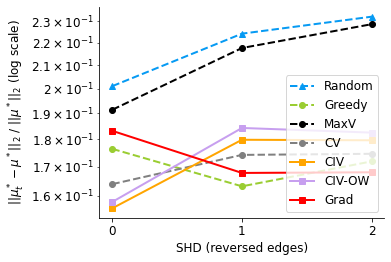

In [9]:
#Reverse edge

plt.clf()
fig, ax = plt.subplots(1,1,figsize=(5.6,3.8))
plt.rcParams.update({'font.size': 12})

plt.yscale('log')

labels = ['Random', 'Greedy', 'MaxV', 'CV', 'CIV', 'CIV-OW', 'Grad']
colors = ['#069AF3', '#9ACD32', 'black', 'grey', 'orange', '#C79FEF', 'red']
markers = ['^', 'o', 'o', 'o', 's', 's', 's']
linestyles = ['--','--','--', '--','-', '-', '-']
for i, k in enumerate(['passive', 'greedy', 'maxv', 'cv', 'civ', 'civow', 'grad']):
    data = [D[i] for D in Data]
    mean = np.array([np.mean(d) for d in data])
    std = np.array([np.std(d) for d in data])
    plt.plot(range(num_edge_max), mean, label=labels[i], linewidth=2, color=colors[i], marker=markers[i], markersize=6, linestyle=linestyles[i])
#     plt.fill_between(range(3), mean - std, mean + std, alpha=.2, color=colors[i])

ax.set_xticks(range(num_edge_max))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# plt.ylim(0.01,1)

plt.legend(loc='lower right')
plt.xlabel(r'SHD (reversed edges)')
plt.ylabel(r'$||\mu_t^*-\mu^*||_2~/~||\mu^*||_2$ (log scale)')
# plt.title(f'relative')
plt.tight_layout()

# plt.savefig('figures/misspecgraphs/excessive_edge.pdf')

<Figure size 432x288 with 0 Axes>

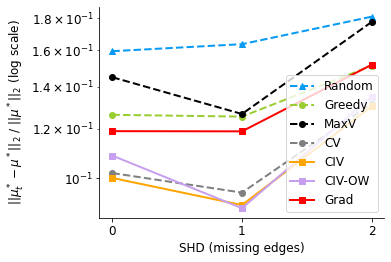

In [18]:
#Remove edge

plt.clf()
fig, ax = plt.subplots(1,1,figsize=(5.6,3.8))
plt.rcParams.update({'font.size': 12})

plt.yscale('log')

labels = ['Random', 'Greedy', 'MaxV', 'CV', 'CIV', 'CIV-OW', 'Grad']
colors = ['#069AF3', '#9ACD32', 'black', 'grey', 'orange', '#C79FEF', 'red']
markers = ['^', 'o', 'o', 'o', 's', 's', 's']
linestyles = ['--','--','--', '--','-', '-', '-']
for i, k in enumerate(['passive', 'greedy', 'maxv', 'cv', 'civ', 'civow', 'grad']):
    data = [D[i] for D in Data]
    mean = np.array([np.mean(d) for d in data])
    std = np.array([np.std(d) for d in data])
    plt.plot(range(num_edge_max), mean, label=labels[i], linewidth=2, color=colors[i], marker=markers[i], markersize=6, linestyle=linestyles[i])
#     plt.fill_between(range(3), mean - std, mean + std, alpha=.2, color=colors[i])

ax.set_xticks(range(num_edge_max))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# plt.ylim(0.01,1)

plt.legend(loc='lower right')
plt.xlabel(r'SHD (missing edges)')
plt.ylabel(r'$||\mu_t^*-\mu^*||_2~/~||\mu^*||_2$ (log scale)')
# plt.title(f'relative')
plt.tight_layout()

# plt.savefig('figures/misspecgraphs/excessive_edge.pdf')